# Projeto 2 - Ciência dos Dados
## Predição do preço de imóveis brasileiros

Nome: Ananda Julia Galvão Campelo

Nome: Carol Magario de Mattos Barretto

Nome: Rafael Dourado Bastos de Oliveira

___
Carregando as bibliotecas necessárias:

In [105]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import os
from scipy import stats, special
import statsmodels.api as sm

# Bibliotecas gráficas para facilitar a vizualização dos dados
import matplotlib.pyplot as plt
import seaborn as sn
from IPython.display import display

# Biblioteca que remove os warnings do Jupter Notbook para uma vizualização mais limpa do documento
import warnings
warnings.filterwarnings('ignore')

In [106]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
c:\Users\Rafael Dourado\Desktop\Programação\Insper\cdados\22-2c-cd-p2-grupo_dj_lovers\notebooks


Carregando a base com todos dados:

In [107]:
path = '../data/'
filename = 'houses_to_rent.csv'

data = pd.read_csv(path+filename, sep=",")

* *city*: Cidade onde o imóvel está localizada
* *area*: Area do imovel [m²]
* *rooms*: Número de quartos 
* *bathroom*: Número de banheiros
* *parking spaces*: Número de vagas no estacionamento
* *floor*: Andar em que está localizado
* *animal*: Aceita animais? [acept/not acept]
* *furniture*: Está Mobilhada? [furnished/not furnished]
* *hoa*: Valor do Condominio [R$]
* *rent amount*: Valor do Aluguel [R$]
* *property tax*: IPTU [R$]
* *fire insurance*: Seguro Incendio [R$]
* *total*: Valor Total do Imóvel [R$]


In [108]:
data.head(10)

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836
5,São Paulo,376,3,3,7,-,acept,not furnished,0,8000,834,121,8955
6,Rio de Janeiro,72,2,1,0,7,acept,not furnished,740,1900,85,25,2750
7,São Paulo,213,4,4,4,4,acept,not furnished,2254,3223,1735,41,7253
8,São Paulo,152,2,2,1,3,acept,furnished,1000,15000,250,191,16440
9,Rio de Janeiro,35,1,1,0,2,acept,furnished,590,2300,35,30,2955


____
### Preparando a base de dados

#### Primeira Simplificação

Um estudo rápido dos dados revelou a variavel  `total` é composta da soma das variáveis `hoa`, `rent_amount`, `property_tax` e `fire_insurance`. Por isso, uma simplificação inicial do modelo que tentará descobrir o valor de uma apartamento será utilizar como **variavel Target** o `rent_amount` (valor do aluguel) e descartar as demais variaveis supracitadas durante a analise.

In [109]:
del data['hoa'], data['property_tax'], data['fire_insurance'], data['total']
data.head(10)

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,rent_amount
0,São Paulo,70,2,1,1,7,acept,furnished,3300
1,São Paulo,320,4,4,0,20,acept,not furnished,4960
2,Porto Alegre,80,1,1,1,6,acept,not furnished,2800
3,Porto Alegre,51,2,1,0,2,acept,not furnished,1112
4,São Paulo,25,1,1,0,1,not acept,not furnished,800
5,São Paulo,376,3,3,7,-,acept,not furnished,8000
6,Rio de Janeiro,72,2,1,0,7,acept,not furnished,1900
7,São Paulo,213,4,4,4,4,acept,not furnished,3223
8,São Paulo,152,2,2,1,3,acept,furnished,15000
9,Rio de Janeiro,35,1,1,0,2,acept,furnished,2300


#### Padronizando os dados

As variaveis `animal` e `furniture` são variaveis qualitativas que possuem apenas dois valores: `possui/aceita` e não `possui/não aceita`. Logo, para padronizar essas variaveis, substituiremos esses valores por `True` e `False`, respectivamente.


In [110]:
data.loc[(data['animal'] == 'acept'), 'animal'] = True
data.loc[(data['animal'] == 'not acept'), 'animal'] = False
data['animal'] = data['animal'].astype('boolean')

data.loc[(data['furniture'] == 'furnished'), 'furniture'] = True
data.loc[(data['furniture'] == 'not furnished'), 'furniture'] = False
data['furniture'] = data['furniture'].astype('boolean')

data.loc[(data['floor'] == '-'), 'floor'] = 0
data['floor'] = data['floor'].astype('int64')

data.head(10)

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,rent_amount
0,São Paulo,70,2,1,1,7,True,True,3300
1,São Paulo,320,4,4,0,20,True,False,4960
2,Porto Alegre,80,1,1,1,6,True,False,2800
3,Porto Alegre,51,2,1,0,2,True,False,1112
4,São Paulo,25,1,1,0,1,False,False,800
5,São Paulo,376,3,3,7,0,True,False,8000
6,Rio de Janeiro,72,2,1,0,7,True,False,1900
7,São Paulo,213,4,4,4,4,True,False,3223
8,São Paulo,152,2,2,1,3,True,True,15000
9,Rio de Janeiro,35,1,1,0,2,True,True,2300


### Análise Exploratória

In [112]:
describe = data.describe()
display(describe.round())

,area,rooms,bathroom,parking_spaces,floor,animal,furniture,rent_amount
count,10692.0,10692.0,10692.0,10692.0,10692.0,10692,10692,10692.0
unique,NaN,NaN,NaN,NaN,NaN,2,2,NaN
top,NaN,NaN,NaN,NaN,NaN,True,False,NaN
freq,NaN,NaN,NaN,NaN,NaN,8316,8086,NaN
mean,149.0,3.0,2.0,2.0,5.0,NaN,NaN,3896.0
std,537.0,1.0,1.0,2.0,5.0,NaN,NaN,3409.0
min,11.0,1.0,1.0,0.0,0.0,NaN,NaN,450.0
25%,56.0,2.0,1.0,0.0,1.0,NaN,NaN,1530.0
50%,90.0,2.0,2.0,1.0,3.0,NaN,NaN,2661.0
75%,182.0,3.0,3.0,2.0,8.0,NaN,NaN,5000.0


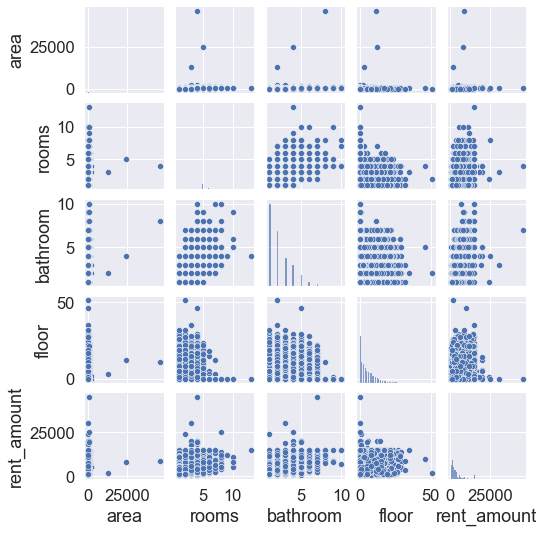

In [113]:
display(sn.pairplot(data[['area', 'rooms', 'bathroom', 'floor', 'rent_amount']], height=1.5))

___
## Classificador automático


In [114]:
def regress(Y,X):
    '''
    Y: coluna do DataFrame utilizada como variável resposta (TARGET)
    X: coluna(s) do DataFrame utilizadas como variável(is) explicativas (FEATURES)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

X = data[['area', 'rooms', 'bathroom', 'floor']]
Y = data['rent_amount']

results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rent_amount   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     2294.
Date:                Wed, 23 Nov 2022   Prob (F-statistic):               0.00
Time:                        16:01:35   Log-Likelihood:                -98826.
No. Observations:               10692   AIC:                         1.977e+05
Df Residuals:                   10687   BIC:                         1.977e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -443.6415     63.572     -6.979      0.000    -568.255    -319.028
area           0.1810      0.046      3.910      0.000       0.090       0.272
rooms        375.0412     30.726     12.206      0.000     314.814     435.269
bathroom    1373.0886     25.656     53.520      0.000    1322.798    1423.379
floor         59.8515      4.565     13.110      0.000      50.903      68.800
==============================================================================
Omnibus:                     4220.176   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33836.069
Skew:                           1.686   Prob(JB):                         0.00
Kurtosis:                      11.036   Cond. No.                     1.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

((array([-3.82711688, -3.60288024, -3.47981512, ...,  3.47981512,
          3.60288024,  3.82711688]),
  array([-12585.16545051,  -9370.46121647,  -8314.20926548, ...,
          22246.14084298,  25135.91022968,  34205.17284812])),
 (2345.1949511015223, -1.0528395122906745e-11, 0.937725012605995))

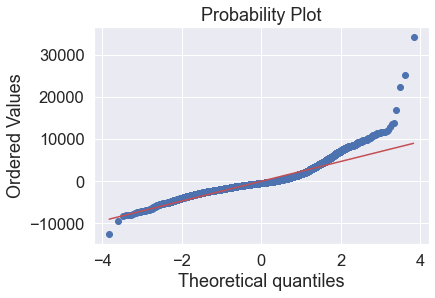

In [115]:
stats.probplot(results.resid, plot=plt, dist=stats.norm)

___
## Referências